In [42]:
from time import time
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler

from pyspark.sql.functions import udf, col

#from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

from sklearn import metrics


In [2]:
# spark = SparkSession.builder.master("spark://spark-master-01:7077").enableHiveSupport().getOrCreate()

In [3]:
spark.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|   1retailprediction|      false|
| default|            anything|      false|
| default|  bestloyalcustomers|      false|
| default|               book1|      false|
| default|ca_sentence_senti...|      false|
| default|             ca_term|      false|
| default|churnloyalprediction|      false|
| default|            customer|      false|
| default| customer_milleneals|      false|
| default|   customer_products|      false|
| default|          customerdm|      false|
| default|           customers|      false|
| default|            cw_table|      false|
| default|             drivers|      false|
| default|               empsk|      false|
| default|           got_terms|      false|
| default|          got_tweets|      false|
| default|            hashtags|      false|
| default|          loyalchurn|      false|
| default|loyalchurn_traintest| 

In [4]:
#df_train =  spark.sql("""SELECT ROW_NUM, TrialID, ObsNum, CAST(IsAlert AS DOUBLE) AS label, P1, P2, CAST(P3 AS DOUBLE), P4, P5,\
#    CAST(P6 AS DOUBLE), P7, CAST(P8 AS DOUBLE),  E1, E2, CAST(E3 AS DOUBLE),CAST(E4 AS DOUBLE),\
#    E5, CAST(E6 AS DOUBLE), CAST(E7 AS DOUBLE), CAST(E8 AS DOUBLE), CAST(E9 AS DOUBLE), CAST(E10 AS DOUBLE),\
#    CAST(E11 AS DOUBLE), V1, V2, CAST(V3 AS DOUBLE), V4, CAST(V5 AS DOUBLE), CAST(V6 AS DOUBLE), CAST(V7 AS DOUBLE),\
#    V8, CAST(V9 AS DOUBLE), CAST(V10 AS DOUBLE), V11 \
#    FROM demo3_train_obd_data""").na.drop()

df_train =  spark.sql("""SELECT trialid, obsnum, ABS(label-1) as label, P1, P2, P3 , P4, P5,\
    P6 , P7, P8 ,  E1, E2, E3 ,E4 ,\
    E5, E6 , E7 , E8 , E9 , E10 ,\
    E11 , V1, V2, V3 , V4, V5 , V6 , V7 ,\
    V8, V9 , V10 , V11 \
    FROM obd_data_for_train""").na.drop()


#X = obd_train_data.toPandas()

In [5]:
# Features to exclude (linear correlations, not required)
features_list = ["TrialID", "ObsNum", "label2", "P1", "P2", "P3", "P4", "P5", "P6", 
    "P7", "P8", "E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8", "E9", "E10", "E11", "V1", "V2", "V3",
    "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11"]

features_exclude_list = ["TrialID","ObsNum","E2","E9","V6","V10","V7","V9","P8","P4"]

for column in features_exclude_list:
    features_list.remove(column)
print(features_list)

df_train.printSchema

['label2', 'P1', 'P2', 'P3', 'P5', 'P6', 'P7', 'E1', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E10', 'E11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V8', 'V11']


<bound method DataFrame.printSchema of DataFrame[trialid: int, obsnum: int, label: double, P1: double, P2: double, P3: int, P4: double, P5: double, P6: int, P7: double, P8: int, E1: double, E2: double, E3: int, E4: int, E5: double, E6: int, E7: int, E8: int, E9: int, E10: int, E11: double, V1: double, V2: double, V3: int, V4: double, V5: int, V6: int, V7: int, V8: double, V9: int, V10: int, V11: double]>

In [6]:
# Assembler of Features
assembler = VectorAssembler(
    inputCols=['P1', 'P2', 'P3', 'P5', 'P6', 'P7', 'E1',
               'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E10', 'E11', 'V1', 
               'V2', 'V3', 'V4', 'V5', 'V8', 'V11'],
    outputCol="features")

#X = assembler.transform(df_train)

#print(X.select("features","label").first())


In [7]:
print("Defining StandardScaler.")
t0 = time()

# Create a StandardScaler for the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                      withStd=True, withMean=False)

# Compute summary of statistics by fitting the StandarScaller
# scalerModel = scaler.fit(X)

# Normalize each feature to have unit standard deviation.
# scaledData = scalerModel.transform(X)
# print(scaledData.select("scaledFeatures","label").first())
print("done in %0.3fs" % (time() - t0))

Defining StandardScaler.
done in 0.009s


In [8]:
# Parameters of CV for Kfold
kfold = 5

seedParam = 42530

In [9]:
# Logistic Regression
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="label", maxIter=10, elasticNetParam=0.8)

lr_pipeline = Pipeline(stages=[assembler, scaler, lr])
#lr_pipeline = Pipeline(stages=[assembler, scaler, lr])

lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()


    
cv_lr = CrossValidator(estimator=lr_pipeline,
                            estimatorParamMaps=lr_paramGrid,
                            evaluator=BinaryClassificationEvaluator(),
                            numFolds=kfold)

print("Train Logistic Regression with CV.")
t0 = time()

cv_lrModel = cv_lr.fit(df_train)

print("done in %0.3fs" % (time() - t0))

Train Logistic Regression with CV.
done in 71.260s


In [10]:
obd_test_data =  spark.sql("""SELECT TrialID, ObsNum, ABS(label-1) AS label, P1, P2, P3, P4, P5, P6, \
    P7, P8, E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11 \
    FROM obd_data_for_test""").na.drop()


In [11]:
df_lr_pred = cv_lrModel.transform(obd_test_data)
df_lr_pred.first()

Row(TrialID=429, ObsNum=591, label=0.0, P1=31.9833, P2=10.9602, P3=852, P4=70.4225, P5=0.097299, P6=844, P7=71.09, P8=0, E1=0.018, E2=164.282, E3=0, E4=0, E5=0.016001, E6=367, E7=0, E8=0, E9=1, E10=41, E11=23.6, V1=0.0, V2=0.175, V3=496, V4=34.5187, V5=1, V6=631, V7=0, V8=0.0, V9=0, V10=1, V11=16.6102, features=DenseVector([31.9833, 10.9602, 852.0, 0.0973, 844.0, 71.09, 0.018, 0.0, 0.0, 0.016, 367.0, 0.0, 0.0, 41.0, 23.6, 0.0, 0.175, 496.0, 34.5187, 1.0, 0.0, 16.6102]), scaledFeatures=DenseVector([4.2727, 2.9157, 2.7564, 0.2661, 0.3363, 3.8227, 0.0013, 0.0, 0.0, 6.9468, 13.3997, 0.0, 0.0, 2.1724, 4.4971, 0.0, 0.4331, 1.662, 0.5463, 2.6039, 0.0, 1.6681]), rawPrediction=DenseVector([1.8451, -1.8451]), probability=DenseVector([0.8636, 0.1364]), prediction=0.0)

In [12]:
#scoreAndLabels = obd_test_predict.select(("probability","label"))
#print(scoreAndLabels.first())
# Compute raw scores on the test set
# predictionAndLabels = obd_test_data.map(lambda lp: (float(cv_lrModel.transform(lp.scaledFeatures), lp.label)))

#predictionAndLabels = obd_test_predict.select("probability","label").rdd
#predictionAndLabels.collect()[:5]
#probabilityPD = obd_test_predict.select("probability").toPandas()



split1_udf = udf(lambda value: np.float(value[0]))
split2_udf = udf(lambda value: np.float(value[1]))

probabilityAndLabelsDF = df_lr_pred.select(split2_udf('probability').alias("probability"),"label")
#print(probabilityAndLabelsDF.describe())
print(probabilityAndLabelsDF)



DataFrame[probability: string, label: double]


In [13]:
probabilityAndLabelsDF.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|34833|
|  1.0|25600|
+-----+-----+



In [14]:
#print(probabilityAndLabelsDF.first())

In [15]:
probabilityAndLabelPD = probabilityAndLabelsDF.toPandas()


In [16]:
probabilityAndLabelPD['probability'] = pd.to_numeric(probabilityAndLabelPD['probability'])

#print(probabilityAndLabelPD['probability'])

In [17]:
fpr_lr, tpr_lr, _ = metrics.roc_curve(probabilityAndLabelPD['label'].as_matrix(),
                                        probabilityAndLabelPD['probability'].as_matrix())
#print(fpr)

roc_auc_lr = metrics.auc(fpr_lr,tpr_lr)

In [18]:
# Decision Tree example

dt = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="label", seed=seedParam)

dt_pipeline = Pipeline(stages=[assembler, scaler, dt])


dt_paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [3, 4, 5])\
    .addGrid(dt.maxBins, [8, 16, 32])\
    .build()

cv_dt = CrossValidator(estimator=dt_pipeline,
                            estimatorParamMaps=dt_paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           numFolds=kfold)


In [19]:
df_train.schema

StructType(List(StructField(trialid,IntegerType,true),StructField(obsnum,IntegerType,true),StructField(label,DoubleType,true),StructField(P1,DoubleType,true),StructField(P2,DoubleType,true),StructField(P3,IntegerType,true),StructField(P4,DoubleType,true),StructField(P5,DoubleType,true),StructField(P6,IntegerType,true),StructField(P7,DoubleType,true),StructField(P8,IntegerType,true),StructField(E1,DoubleType,true),StructField(E2,DoubleType,true),StructField(E3,IntegerType,true),StructField(E4,IntegerType,true),StructField(E5,DoubleType,true),StructField(E6,IntegerType,true),StructField(E7,IntegerType,true),StructField(E8,IntegerType,true),StructField(E9,IntegerType,true),StructField(E10,IntegerType,true),StructField(E11,DoubleType,true),StructField(V1,DoubleType,true),StructField(V2,DoubleType,true),StructField(V3,IntegerType,true),StructField(V4,DoubleType,true),StructField(V5,IntegerType,true),StructField(V6,IntegerType,true),StructField(V7,IntegerType,true),StructField(V8,DoubleType,

In [20]:
print("Train Decision Tree with CV.")
t0 = time()

cv_dtModel = cv_dt.fit(df_train)
print("done in %0.3fs" % (time() - t0))

Train Decision Tree with CV.
done in 228.372s


In [21]:
df_dt_pred = cv_dtModel.transform(obd_test_data)

In [22]:
probabilityAndLabelsDF = df_dt_pred.select(split2_udf('probability').alias("probability"),"label")

In [23]:
probabilityAndLabelPD = probabilityAndLabelsDF.toPandas()
probabilityAndLabelPD['probability'] = pd.to_numeric(probabilityAndLabelPD['probability'])

In [24]:
fpr_dt, tpr_dt, _ = metrics.roc_curve(probabilityAndLabelPD['label'].as_matrix(),
                                        probabilityAndLabelPD['probability'].as_matrix())
#print(fpr)

roc_auc_dt = metrics.auc(fpr_dt,tpr_dt)

In [25]:
# Random Forest example

rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", seed = seedParam)

rf_pipeline = Pipeline(stages=[assembler, scaler, rf])


rf_paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [20, 40])\
    .addGrid(rf.maxBins, [8, 16, 32])\
    .addGrid(rf.maxDepth, [3, 4, 5])\
    .build()

cv_rf = CrossValidator(estimator=rf_pipeline,
                            estimatorParamMaps=rf_paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           numFolds=kfold)

In [26]:
print("Train Random Forest with CV.")
t0 = time()

cv_rfModel = cv_rf.fit(df_train)
print("done in %0.3fs" % (time() - t0))

Train Random Forest with CV.
done in 1091.328s


In [27]:
df_rf_pred = cv_rfModel.transform(obd_test_data)

In [28]:
probabilityAndLabelsDF = df_rf_pred.select(split2_udf('probability').alias("probability"),"label")

In [29]:
probabilityAndLabelPD = probabilityAndLabelsDF.toPandas()
probabilityAndLabelPD['probability'] = pd.to_numeric(probabilityAndLabelPD['probability'])

In [30]:
fpr_rf, tpr_rf, _ = metrics.roc_curve(probabilityAndLabelPD['label'].as_matrix(),
                                        probabilityAndLabelPD['probability'].as_matrix())
#print(fpr)

roc_auc_rf = metrics.auc(fpr_rf,tpr_rf)

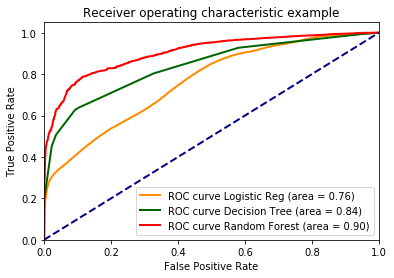

In [31]:
plt.figure()
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange',
         lw=lw, label='ROC curve Logistic Reg (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr_dt, tpr_dt, color='darkgreen',
         lw=lw, label='ROC curve Decision Tree (area = %0.2f)' % roc_auc_dt)
plt.plot(fpr_rf, tpr_rf, color='red',
         lw=lw, label='ROC curve Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [32]:
df_rf_pred.describe

<bound method DataFrame.describe of DataFrame[TrialID: int, ObsNum: int, label: double, P1: double, P2: double, P3: int, P4: double, P5: double, P6: int, P7: double, P8: int, E1: double, E2: double, E3: int, E4: int, E5: double, E6: int, E7: int, E8: int, E9: int, E10: int, E11: double, V1: double, V2: double, V3: int, V4: double, V5: int, V6: int, V7: int, V8: double, V9: int, V10: int, V11: double, features: vector, scaledFeatures: vector, rawPrediction: vector, probability: vector, prediction: double]>

In [33]:
pd_rd_data = df_rf_pred.select(['TrialID', 'ObsNum','P1', 'P2', 'P3', 'P5', 'P6', 'P7', 'E1',
               'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E10', 'E11', 'V1', 
               'V2', 'V3', 'V4', 'V5', 'V8', 'V11']).toPandas()

In [34]:
pd_rd_data.head()

,TrialID,ObsNum,P1,P2,P3,P5,P6,P7,E1,E3,...,E8,E10,E11,V1,V2,V3,V4,V5,V8,V11
0,429,591,31.9833,10.96020,852,0.097299,844,71.0900,0.018,0,...,0,41,23.6,0.00,0.175,496,34.51870,1,0.0,16.61020
1,309,453,29.0343,13.79750,1948,0.137516,1100,54.5455,29.171,0,...,3,63,0.0,102.16,0.070,767,0.00000,0,13.4,7.19820
2,228,176,30.8788,9.29190,1200,0.293195,776,77.3196,0.000,0,...,0,72,0.0,0.00,0.000,240,10.50000,0,0.0,16.17160
3,280,335,32.5191,13.36230,1728,1.052130,876,68.4932,28.344,0,...,0,43,0.0,99.20,0.175,496,3.01875,0,14.3,4.53946
4,150,173,37.5742,8.20535,992,0.096002,880,68.1818,31.700,0,...,2,63,0.0,114.88,-0.455,255,0.00000,0,31.9,8.56671


In [35]:
pd_rd_data['prediction'] = pd.Series((1-probabilityAndLabelPD['probability'].as_matrix()), index=pd_rd_data.index)

In [36]:
pd_rd_data.head()

,TrialID,ObsNum,P1,P2,P3,P5,P6,P7,E1,E3,...,E10,E11,V1,V2,V3,V4,V5,V8,V11,prediction
0,429,591,31.9833,10.96020,852,0.097299,844,71.0900,0.018,0,...,41,23.6,0.00,0.175,496,34.51870,1,0.0,16.61020,0.856818
1,309,453,29.0343,13.79750,1948,0.137516,1100,54.5455,29.171,0,...,63,0.0,102.16,0.070,767,0.00000,0,13.4,7.19820,0.328541
2,228,176,30.8788,9.29190,1200,0.293195,776,77.3196,0.000,0,...,72,0.0,0.00,0.000,240,10.50000,0,0.0,16.17160,0.912340
3,280,335,32.5191,13.36230,1728,1.052130,876,68.4932,28.344,0,...,43,0.0,99.20,0.175,496,3.01875,0,14.3,4.53946,0.214469
4,150,173,37.5742,8.20535,992,0.096002,880,68.1818,31.700,0,...,63,0.0,114.88,-0.455,255,0.00000,0,31.9,8.56671,0.507967


In [37]:
pd_rd_data.to_csv('prediction.csv')

In [38]:
fpr_rf, tpr_rf, threshold = metrics.roc_curve(probabilityAndLabelPD['label'].as_matrix(),
                                        probabilityAndLabelPD['probability'].as_matrix())

In [39]:
threshold

array([ 0.99425604,  0.99406136,  0.99400736, ...,  0.08176263,
        0.07918116,  0.07744958])

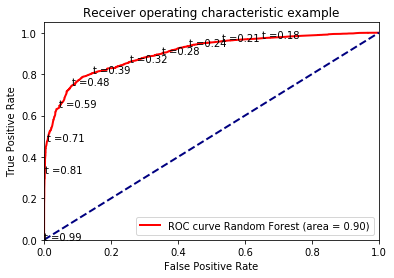

In [40]:
plt.figure()
lw = 2
plt.plot(fpr_rf, tpr_rf, color='red',
         lw=lw, label='ROC curve Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i in range(0,len(threshold)/1000):
    pos = i*1000
    if pos>len(threshold): pos=len(threshold)
    plt.annotate('t =%1.2f' % threshold[pos], xy = (fpr_rf[pos], tpr_rf[pos]), textcoords='data' )
    
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [41]:
cv_rfModel.bestModel.write().overwrite().save("hdfs://ussm-mag-hdpc01.lab.opentext.com/opentext/models/odb")